# LSTM Stock Predictor Using Closing Prices

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin closing prices to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [176]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [177]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [178]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('Data/btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [179]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('Data/btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [180]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [181]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [182]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [183]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 1

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[9114.719727]
 [8870.820313]
 [9251.269531]] 

y sample values:
[[8870.820313]
 [9251.269531]
 [8218.049805]]


In [184]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [185]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)


In [186]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.7111066 ]]

 [[0.68162134]]

 [[0.72761425]]] 

X_test sample values:
[[[0.04651042]]

 [[0.05299984]]

 [[0.05299984]]]


---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [187]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [188]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.15

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout_fraction))

# Layer 4
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(units=1, activation="sigmoid"))


In [189]:
# Compile the model
model.compile(loss="mean_absolute_error",
    optimizer="adam",)

In [190]:
# Summarize the model
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 1, 30)             3840      
                                                                 
 dropout_32 (Dropout)        (None, 1, 30)             0         
                                                                 
 lstm_33 (LSTM)              (None, 1, 30)             7320      
                                                                 
 dropout_33 (Dropout)        (None, 1, 30)             0         
                                                                 
 lstm_34 (LSTM)              (None, 1, 30)             7320      
                                                                 
 dropout_34 (Dropout)        (None, 1, 30)             0         
                                                                 
 lstm_35 (LSTM)              (None, 30)               

In [191]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=100, shuffle=False, batch_size=10, verbose=1)

Epoch 1/100
38/38 [==============================] - 5s 3ms/step - loss: 0.2064
Epoch 2/100
38/38 [==============================] - 0s 3ms/step - loss: 0.2017
Epoch 3/100
38/38 [==============================] - 0s 4ms/step - loss: 0.1986
Epoch 4/100
38/38 [==============================] - 0s 4ms/step - loss: 0.1943
Epoch 5/100
38/38 [==============================] - 0s 4ms/step - loss: 0.1869
Epoch 6/100
38/38 [==============================] - 0s 4ms/step - loss: 0.1774
Epoch 7/100
38/38 [==============================] - 0s 4ms/step - loss: 0.1603
Epoch 8/100
38/38 [==============================] - 0s 4ms/step - loss: 0.1201
Epoch 9/100
38/38 [==============================] - 0s 4ms/step - loss: 0.0827
Epoch 10/100
38/38 [==============================] - 0s 4ms/step - loss: 0.0550
Epoch 11/100
38/38 [==============================] - 0s 4ms/step - loss: 0.0470
Epoch 12/100
38/38 [==============================] - 0s 4ms/step - loss: 0.0441
Epoch 13/100
38/38 [=================

---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [192]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)

6/6 [==============================] - 1s 2ms/step - loss: 0.0522


0.05218997970223427

In [193]:
# Make some predictions
predicted = model.predict(X_test)

In [194]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [195]:
# Create a DataFrame of Real and Predicted values
prices = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
prices.head()

,Real,Predicted
2019-02-17,3670.919922,3577.083252
2019-02-18,3670.919922,3599.769531
2019-02-19,3912.570068,3599.769531
2019-02-20,3924.239990,3719.621094
2019-02-21,3974.050049,3726.189209


<AxesSubplot:title={'center':'Actual Vs. Predicted BTC Prices Using Closing Price'}>

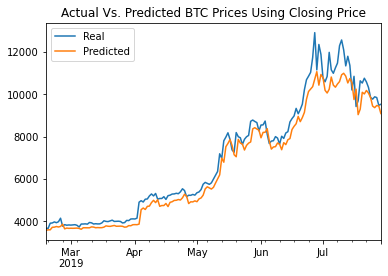

In [196]:
# Plot the real vs predicted values as a line chart
prices.plot(title="Actual Vs. Predicted BTC Prices Using Closing Price")